<a href="https://colab.research.google.com/github/abyaadrafid/BHGD/blob/master/bangla_handwritten_grapheme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

2

In [0]:
torch.set_num_threads(4)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/gdrive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/gdrive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_dfs(['/content/gdrive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/gdrive/My Drive/kaggle/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

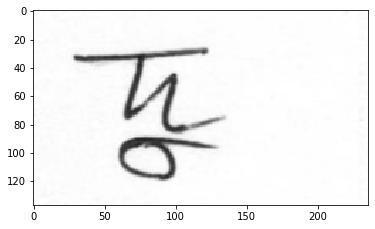

In [10]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [0]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [13]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(nn.Linear(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
        base = models.resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.base = base
        feature_size = 512
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 2)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 1)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 1)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [0]:
model.convert_to_grayscale()

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=256, num_workers=0,shuffle=True)
va_dl = DataLoader(va_ds, batch_size=256, num_workers=0)

In [0]:
def make_one_hot(y,nb_classes):
  bs = y.size()[0]
  y_onehot = torch.FloatTensor(bs,nb_classes).cuda()
  y_onehot=y_onehot.zero_()
  y_onehot= y_onehot.scatter_(1,y.view(-1,1),1)

  return y_onehot

In [0]:
def mixup_data(x, g,v,c, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    g_m = g*lam + g[index]*(1-lam)
    v_m = v*lam + v[index]*(1-lam)
    c_m = c*lam + c[index]*(1-lam)
    return mixed_x, g_m, v_m, c_m

In [0]:
criterion = nn.BCEWithLogitsLoss()

In [0]:
tr_losses = []
va_losses = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
nb_graphmeme = 168
nb_vowel = 11
nb_cons = 7

In [0]:
from random import randrange
def rand_pct():
  val = randrange(10)
  if(val == 5):
    return 0
  return 0

In [0]:
def run_epochs(num_epochs):
  epochs = range(num_epochs)
  epochs = tqdm_notebook(range(num_epochs))
  for epoch in epochs:
      model.train()
      count = 0
      batches = tr_dl
      batches = tqdm_notebook(tr_dl)
      for batch in batches:
          count += 1
          optimizer.zero_grad()

          img, g, v, c = batch
          img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
          img = img / 255.0
          g_o = make_one_hot(g,nb_graphmeme)
          v_o = make_one_hot(v,nb_vowel)
          c_o = make_one_hot(c,nb_cons)

          if(rand_pct()) :
            img,g_m,v_m,c_m,lam=mixup_data(img,g_o,v_o,c_o,alpha=0.1)
          
          g_pred, v_pred, c_pred = model(img)
          g_loss = criterion(g_pred,g_o)
          v_loss = criterion(v_pred,v_o)
          c_loss = criterion(c_pred,c_o)

          loss = g_loss + v_loss + c_loss
          loss.backward()

          optimizer.step()

          tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
      print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
      
      with torch.no_grad():
          model.eval()
          avg_g_loss = 0.0
          avg_v_loss = 0.0
          avg_c_loss = 0.0
          g_true = []
          v_true = []
          c_true = []
          g_preds = []
          v_preds = []
          c_preds = []
          count = 0

          batches = va_dl
          batches = tqdm_notebook(va_dl)
          for batch in batches:
              count += 1
              img, g, v, c = batch
              img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)          
              img = img / 255.0

              g_pred, v_pred, c_pred = model(img)
              g_o = make_one_hot(g,nb_graphmeme)
              v_o = make_one_hot(v,nb_vowel)
              c_o = make_one_hot(c,nb_cons)
              g_loss = criterion(g_pred,g_o)
              v_loss = criterion(v_pred,v_o)
              c_loss = criterion(c_pred,c_o)

              avg_g_loss += g_loss.item()
              avg_v_loss += v_loss.item()
              avg_c_loss += c_loss.item()

              g_true.extend(g.tolist())
              v_true.extend(v.tolist())
              c_true.extend(c.tolist())
              g_preds.extend(g_pred.argmax(1).tolist())
              v_preds.extend(v_pred.argmax(1).tolist())
              c_preds.extend(c_pred.argmax(1).tolist())

          avg_g_loss /= count
          avg_v_loss /= count
          avg_c_loss /= count
          va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
          print(sum(va_losses[-1]), va_losses[-1])
          
          print(recall_score(g_true, g_preds, average='macro'))
          print(recall_score(v_true, v_preds, average='macro'))
          print(recall_score(c_true, c_preds, average='macro'))
          print(confusion_matrix(v_true, v_preds))
          print(confusion_matrix(c_true, c_preds))
          plt.figure(figsize = (20, 20))
          sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
          plt.show()

1.083273071516437 0.37616242798205984 0.34619336174814164 0.36091728178623544


0.3236073156512236 (0.07983377575874329, 0.11514395494249803, 0.1286295849499823)
0.010907330045407648
0.8174010016572203
0.7448832911131523
[[3875  151    0   26   95   15   80    6    0    0    0]
 [  93 3456    0  104    2    1    1    1    0    4    0]
 [ 124   21 2329   44    5    0    1    6   42    2    3]
 [   8    9    0 1561    0    0    0    0    0    0    1]
 [ 222   11    0    3 1617    4   24    0    0    0    0]
 [ 103   35    0    0  142  100  142    0    0    0    0]
 [  61    6    0    0   24    5  352    0    0    0    0]
 [ 146   22    1    1   22    2    1 2556   51   45   12]
 [  28   14    1    1    1    1    0   15  269    0    3]
 [   0  169    0    1    0    0    0   77    5 1262  104]
 [   0    1    0   18    0    0    0    6    1    1  330]]
[[12346     0   122     0     8    79     0]
 [  119   521    50     0     1     2     0]
 [  307     0  1978     0     0    23     0]
 [    4     0    25    28     5     0     0]
 [  489     1    18     2  1624     0   

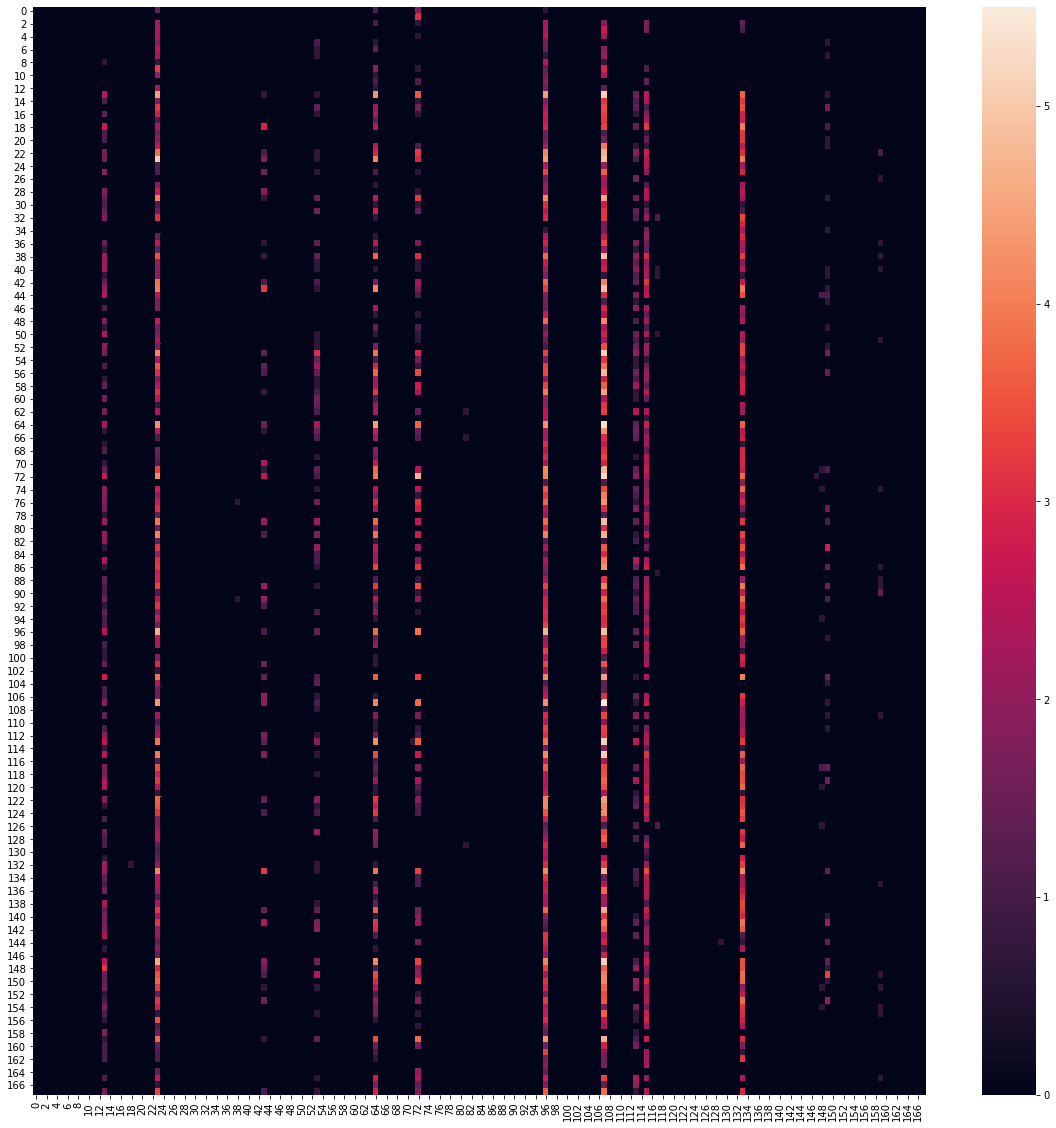

0.6342559189508015 0.21212701090312494 0.2041906469621428 0.21793826108553369


0.1439182908757578 (0.033788971555761146, 0.05412921790457979, 0.056000101415416864)
0.05981842806848095
0.8783564649641092
0.8851417754511417
[[4022   55    7    4   58   14   17   64    4    3    0]
 [ 231 3314    2   33    4    3    1   33    3   38    0]
 [   6    0 2562    1    0    0    0    7    1    0    0]
 [  22   11    2 1535    0    0    0    7    0    0    2]
 [ 147    2    0    0 1688   18    7   19    0    0    0]
 [  93    1    0    0   38  355   21   11    3    0    0]
 [  56    0    0    0    5   20  362    5    0    0    0]
 [   6    0    1    0    0    0    0 2837    4   11    0]
 [   1    0    8    0    0    0    0   54  268    1    1]
 [   0    9    1    0    0    0    0  287    9 1301   11]
 [   0    0    0    0    0    0    0   33    0   18  306]]
[[12348    13    81     0    17    96     0]
 [   36   644    11     0     1     1     0]
 [  181     8  2103     0     0    16     0]
 [    3     0     5    52     2     0     0]
 [  299     2    17     8  1806     1 

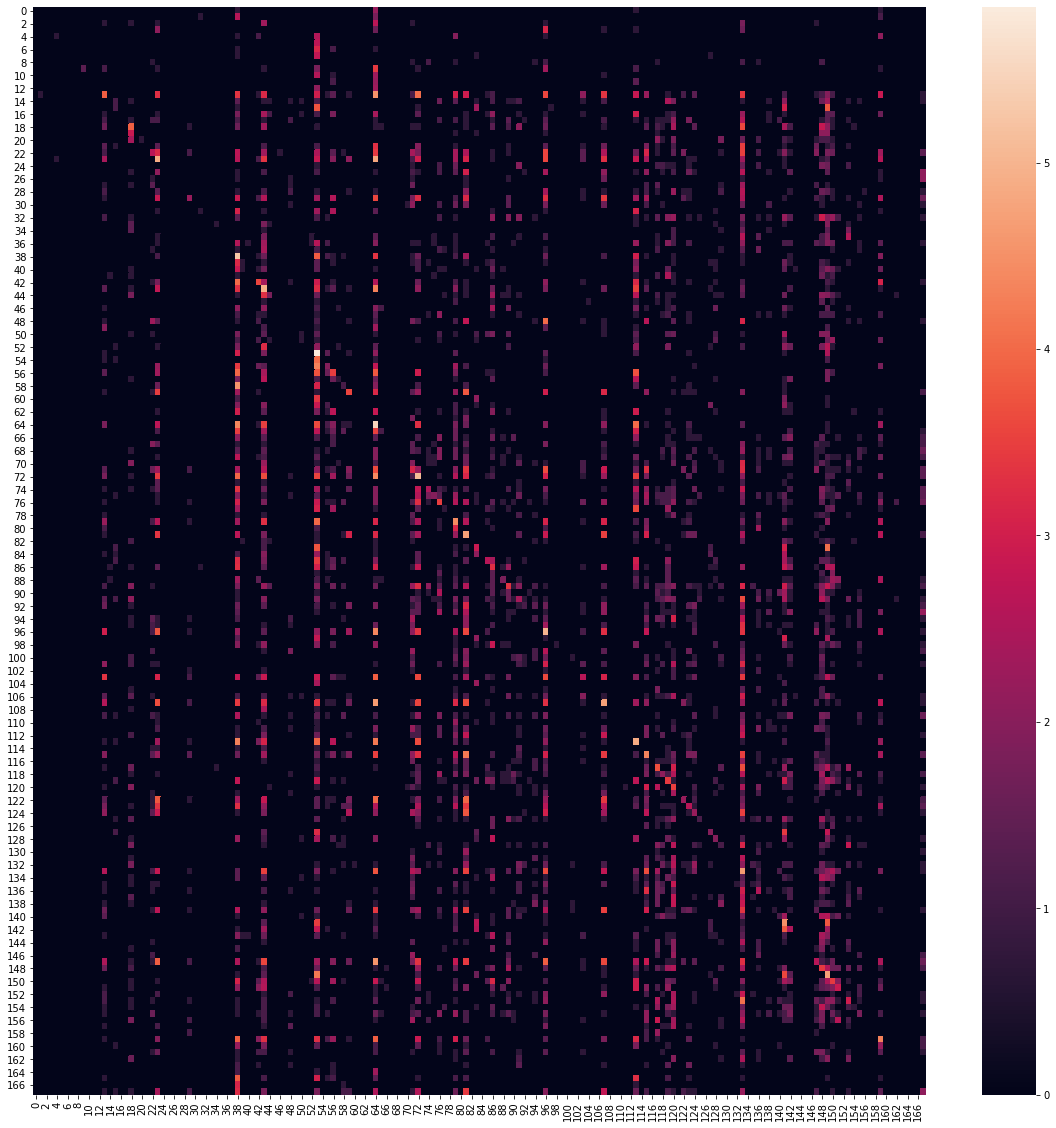

0.45704264044480636 0.15087313041747852 0.14664244377622904 0.1595270662510988


0.22808558569301532 (0.025072969260472287, 0.04892591061660006, 0.15408670581594297)
0.13472526798918577
0.870025541507217
0.8532196761496277
[[3634   49    2    4  344  113    1   80    9   12    0]
 [ 111 3351    0   11   13   47    0   14    7  108    0]
 [   5    0 2525    1    1    0    0   27   17    1    0]
 [  13   58    1 1460    1    1    0    4    1    8   32]
 [  40    1    0    0 1813   17    1    9    0    0    0]
 [  11    1    0    0   61  449    0    0    0    0    0]
 [  34    0    0    0   36  186  188    4    0    0    0]
 [   3    0    1    0    0    0    0 2814   17   23    1]
 [   0    0    1    0    0    0    0   24  305    1    2]
 [   0    4    0    0    0    1    0   85    4 1515    9]
 [   0    0    0    0    0    0    0   20    0   46  291]]
[[11097     7    16     0    32  1403     0]
 [   43   625     7     0     1    17     0]
 [  439     2  1731     2     1   133     0]
 [    1     0     0    52     7     2     0]
 [   99     0    11     0  1909    70  

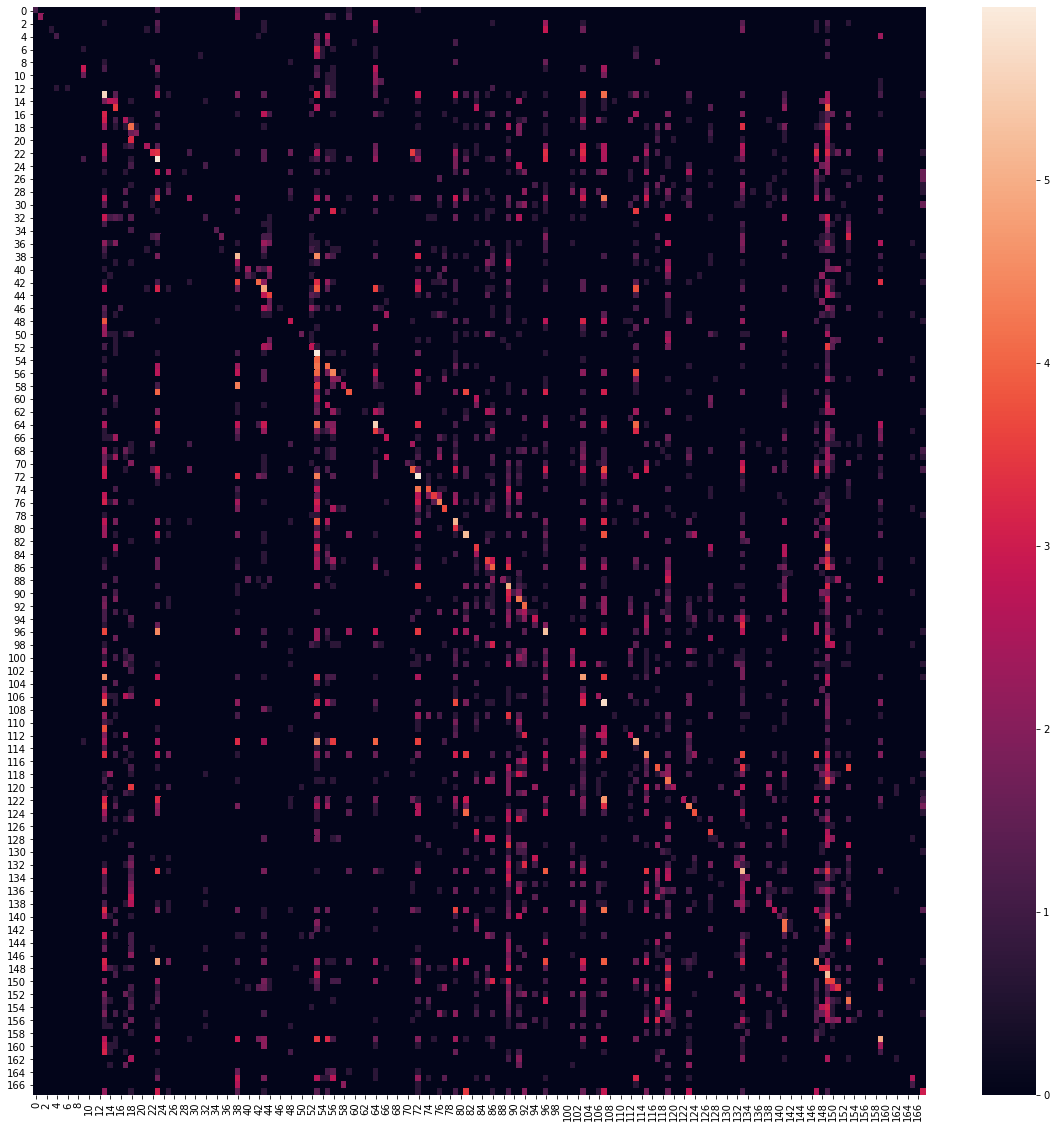

0.3615918624362364 0.11829836719473126 0.1157718398588508 0.12752165538265436


0.12274510296698235 (0.01967377734335163, 0.02889375535983451, 0.07417757026379622)
0.3677782070605843
0.9128398203319329
0.8361186402740917
[[4061  108    3    4   29    4    0   37    0    2    0]
 [  48 3581    0   10    2    1    1    2    0   17    0]
 [   9    1 2558    1    1    0    0    7    0    0    0]
 [   4   28    0 1541    0    0    0    0    1    0    5]
 [ 182    6    1    0 1675    5    1   11    0    0    0]
 [  75    1    0    0   42  396    6    2    0    0    0]
 [  90    0    0    0    8    9  340    1    0    0    0]
 [   7    2    1    0    0    0    0 2813    4   31    1]
 [   3    2    3    0    0    0    0   38  278    4    5]
 [   0   13    0    0    0    0    0   53    2 1521   29]
 [   0    0    0    0    0    0    0    4    0    6  347]]
[[12280    13    44     0   209     9     0]
 [   20   667     5     0     1     0     0]
 [  205    13  2074     6     7     3     0]
 [    0     0     0    55     7     0     0]
 [   31     0    10     0  2105     0   

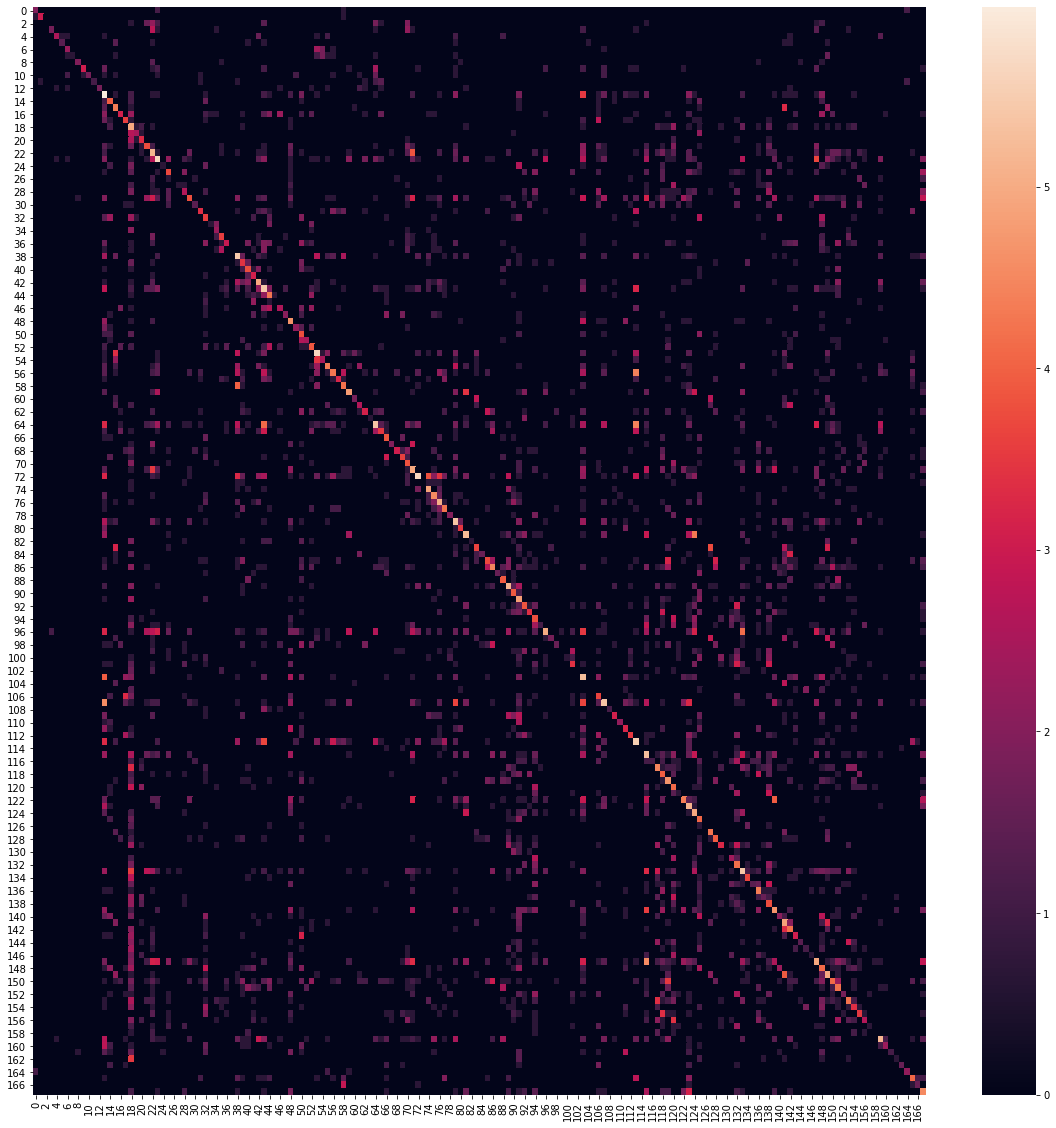

In [29]:
run_epochs(4)

0.30008772055920124 0.09776180235476693 0.09580167448806776 0.10652424371636655


0.1024387959343723 (0.01785770438234263, 0.041157712358274035, 0.04342337919375564)
0.3915094621244511
0.8942923213742643
0.9245460856163122
[[3637   44    3    9  518    3    2   30    1    1    0]
 [  87 3482    1   48   21    1    1    4    0   17    0]
 [   4    0 2566    1    3    0    0    3    0    0    0]
 [   0    8    0 1570    1    0    0    0    0    0    0]
 [  15    0    0    0 1864    1    1    0    0    0    0]
 [  23    3    0    0  241  254    1    0    0    0    0]
 [  25    0    0    0   83    8  331    1    0    0    0]
 [   5    1    2    1    9    0    0 2800   12   26    3]
 [   1    0    3    0    1    0    0   15  310    1    2]
 [   0    7    1    0    0    0    0   44    2 1546   18]
 [   0    0    0    0    0    0    0    7    0    8  342]]
[[12191     3   282     0    29    50     0]
 [   17   650    25     0     1     0     0]
 [   64     3  2234     1     1     5     0]
 [    0     0     2    59     1     0     0]
 [  108     0    16     0  2015     0   

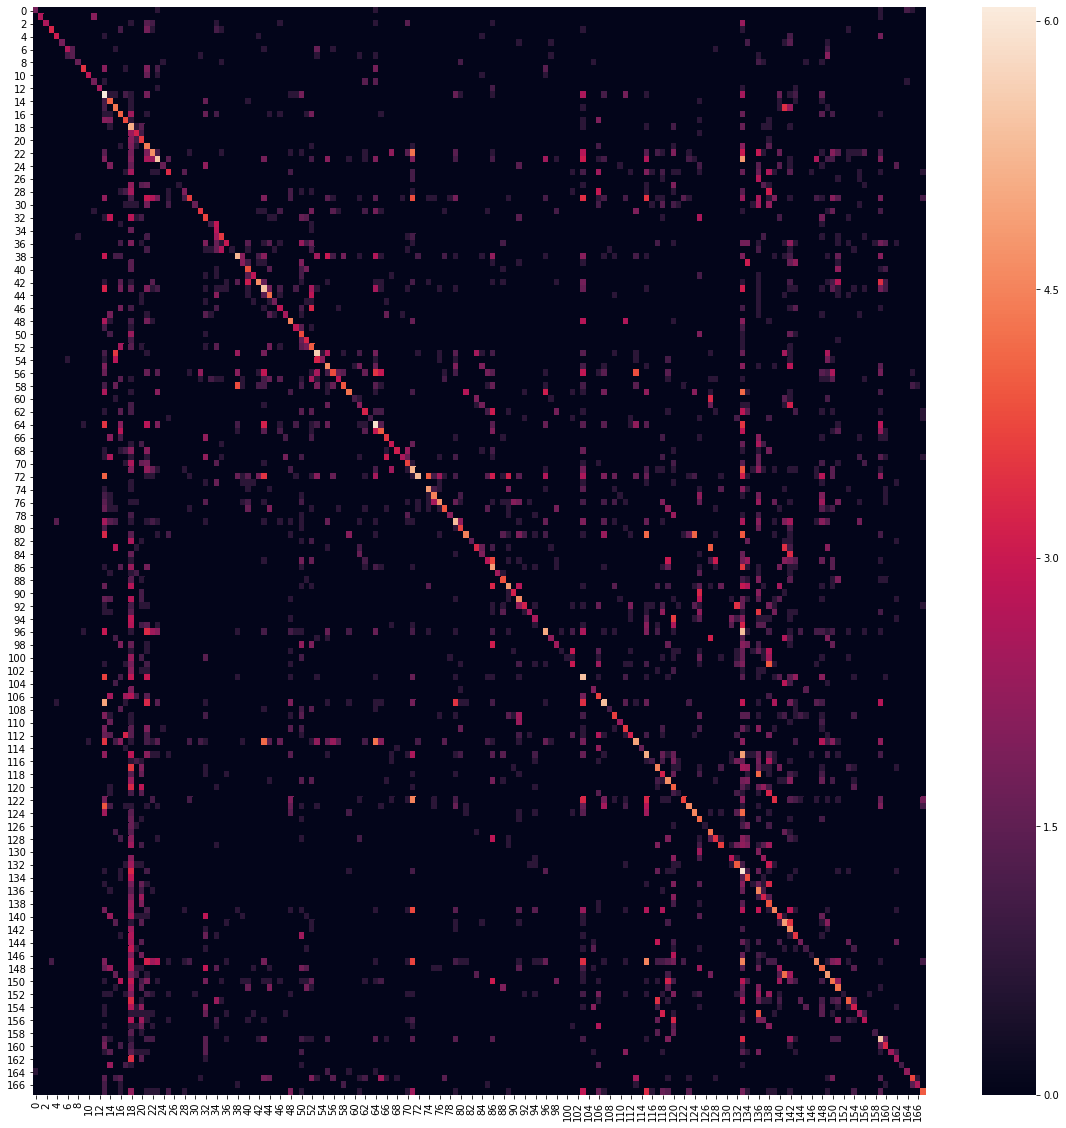

0.25703054372171175 0.08354583995847953 0.08188595414295168 0.09159874962028054


0.1015516407316244 (0.01422781411181145, 0.030955054207787484, 0.056368772412025474)
0.5837376338832785
0.9199625057513949
0.8738745764207414
[[4013   51    1    5  166    2    6    4    0    0    0]
 [ 121 3511    1   16    4    0    3    1    0    5    0]
 [  18    0 2553    1    2    0    0    2    1    0    0]
 [   6   15    0 1556    0    0    1    0    0    0    1]
 [  49    2    0    0 1823    1    6    0    0    0    0]
 [  42    5    0    0  106  347   22    0    0    0    0]
 [  15    0    0    0   18    3  412    0    0    0    0]
 [  50    2    1    1    7    0    0 2780    7   11    0]
 [   5    2    2    0    1    0    0   20  301    1    1]
 [   1   69    0    0    0    0    0  130    2 1397   19]
 [   0    0    0    2    0    0    0   14    0    3  338]]
[[12455     3    61     0    12    24     0]
 [   41   636    15     0     1     0     0]
 [  171     0  2130     0     0     7     0]
 [    0     0     2    51     9     0     0]
 [  225     0    14     0  1902     0  

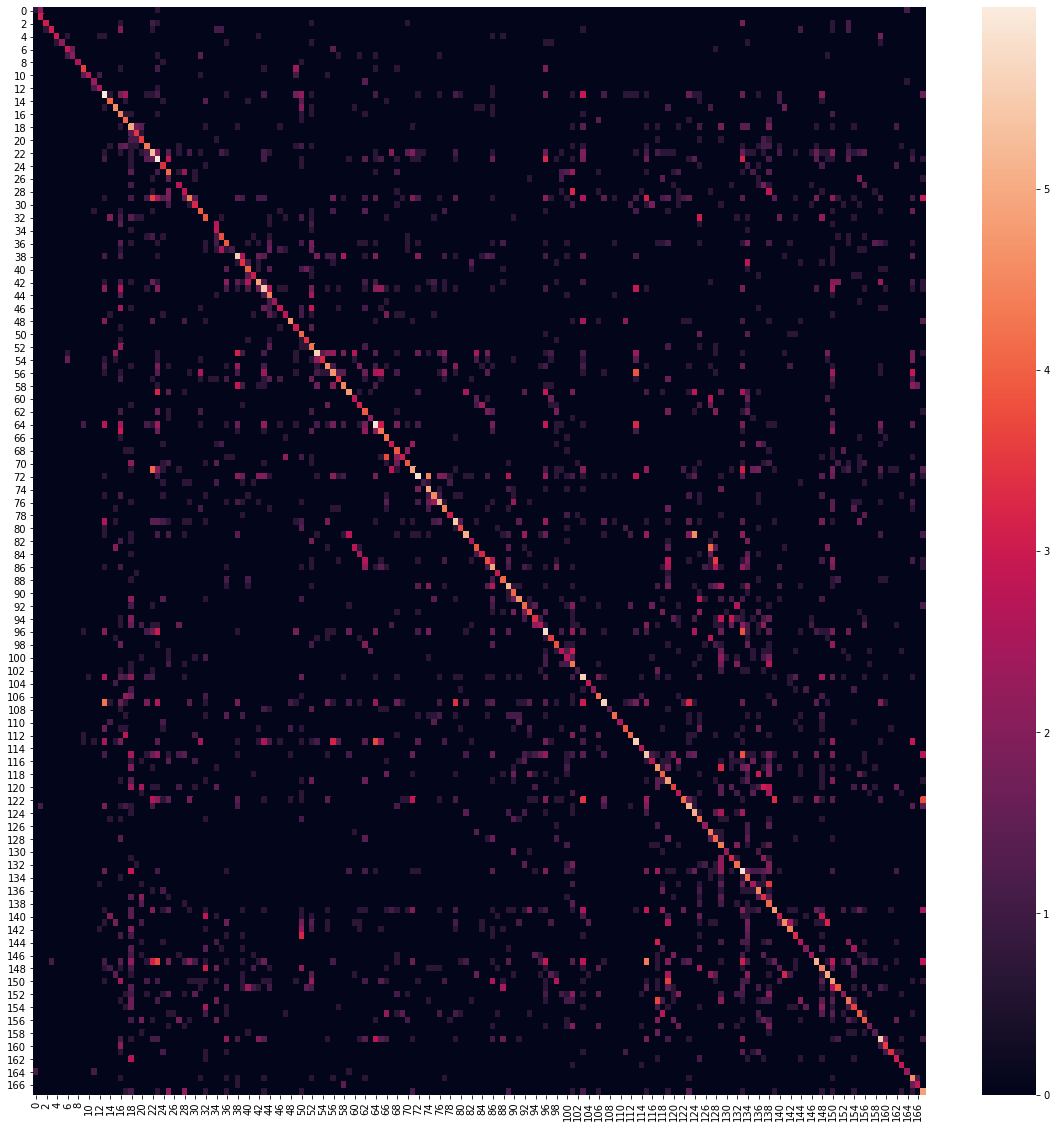

0.22505128855046783 0.07309013342845769 0.07159097307705287 0.08037018204495727


0.09993615003797826 (0.012194508498039427, 0.04112478590841535, 0.04661685563152349)
0.5529424765783418
0.9103972990791064
0.9342498374206691
[[3966   51   34   73   95   14    0   14    1    0    0]
 [  60 3320    5  257    4    2    1    2    0    9    2]
 [   1    0 2574    1    1    0    0    0    0    0    0]
 [   1    4    0 1574    0    0    0    0    0    0    0]
 [  54    2    1    2 1817    2    1    1    1    0    0]
 [  31    3    0    3   67  416    2    0    0    0    0]
 [  85    0    1    0   29   24  308    1    0    0    0]
 [  14    2   14    2    3    0    0 2710   53   23   38]
 [   0    0   10    0    1    0    0    7  308    1    6]
 [   0   10    1    4    0    1    0   45    4 1411  142]
 [   0    0    0    2    0    0    0    2    0    2  351]]
[[12023     1   237     0    66   227     1]
 [   36   618    35     0     1     3     0]
 [   68     0  2224     2     1    13     0]
 [    0     0     1    58     3     0     0]
 [   60     0    12     0  2063     4  

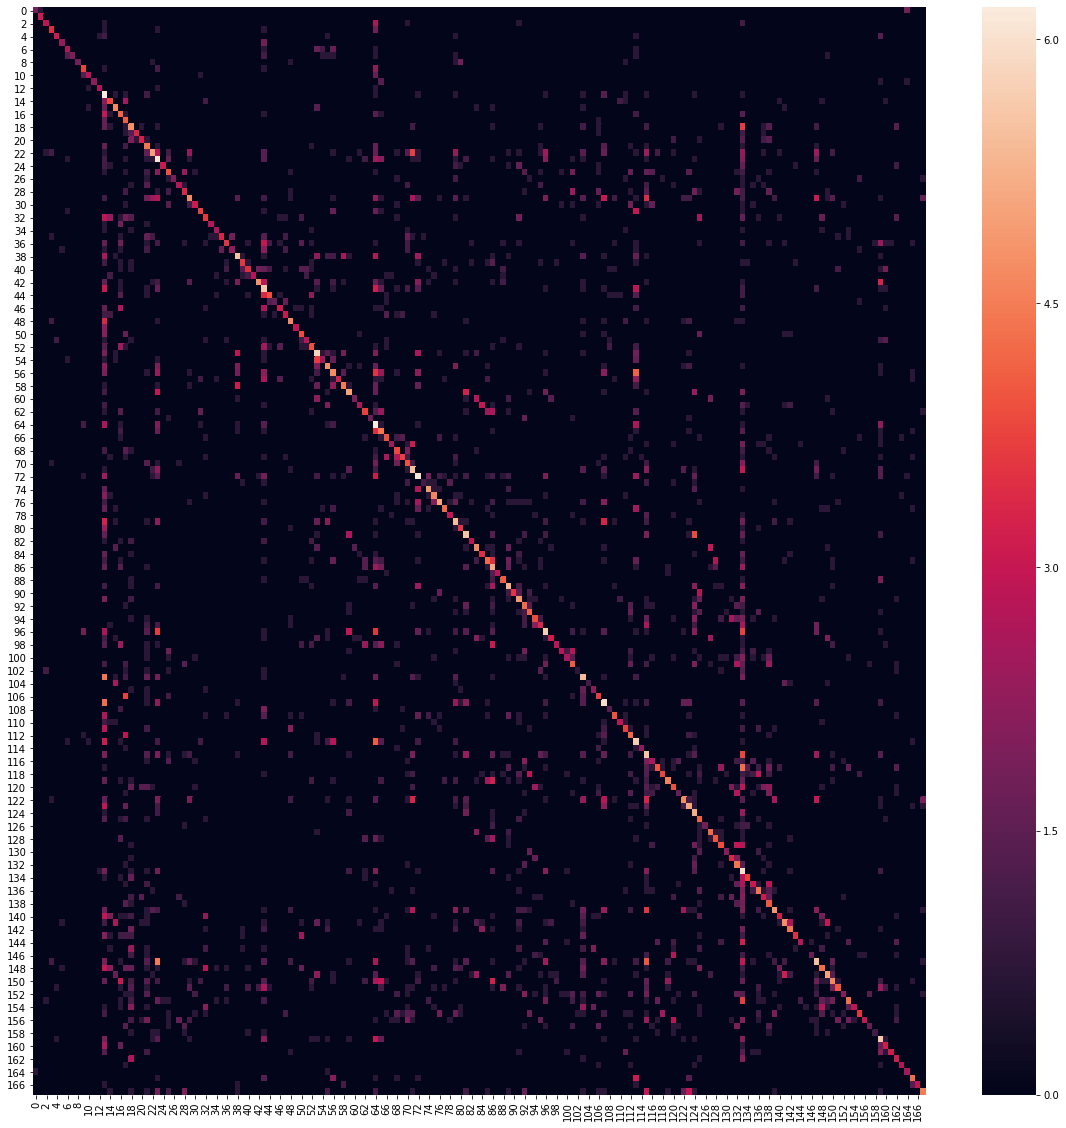

In [30]:
run_epochs(3)

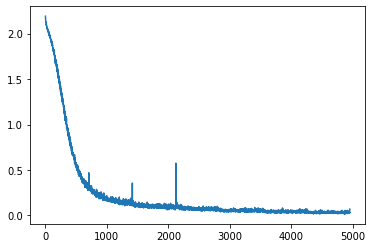

In [31]:
plt.plot([sum(t) for t in tr_losses])

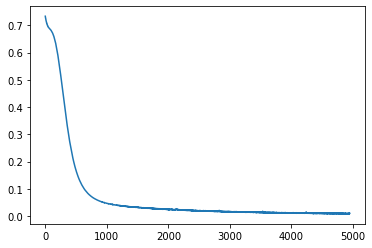

In [32]:
plt.plot([t[0] for t in tr_losses])

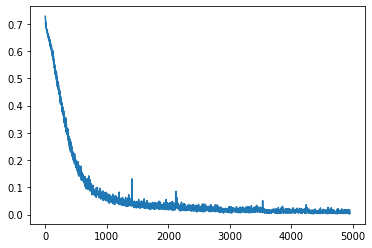

In [33]:
plt.plot([t[1] for t in tr_losses])

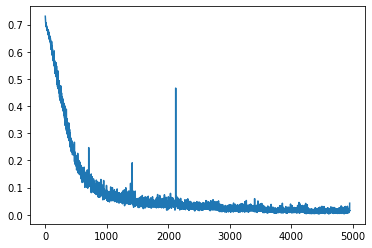

In [34]:
plt.plot([t[2] for t in tr_losses])

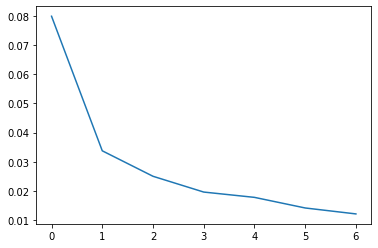

In [35]:
plt.plot([t[0] for t in va_losses])

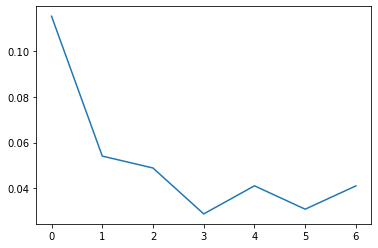

In [36]:
plt.plot([t[1] for t in va_losses])

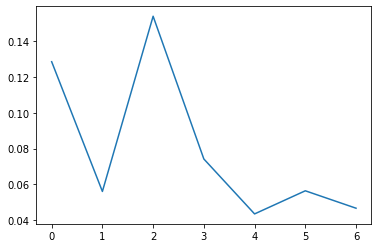

In [37]:
plt.plot([t[2] for t in va_losses])

In [0]:
torch.save(model.state_dict(), 'model.pth')

0.20030774307413202 0.06506013505613956 0.06360633168715732 0.07164127633083514


0.11449488710989303 (0.010683536824263349, 0.06223377561833285, 0.041577574667296835)
0.6083951991420045
0.925082832251643
0.9430712230586648
[[3724  126   36  234   40   18   22   35    8    4    1]
 [  20 3070    3  514    1    1    1    0    1   48    3]
 [   1    0 2571    3    0    0    0    1    1    0    0]
 [   1    1    0 1576    0    0    0    0    0    0    1]
 [  84    1    2   17 1737   23    8    8    1    0    0]
 [  18    4    1    7   23  462    7    0    0    0    0]
 [  14    0    0    4    6   17  407    0    0    0    0]
 [   3    1    7    1    0    0    0 2621   33  117   76]
 [   0    0    7    0    0    0    0    8  305    5    8]
 [   0    1    0    3    0    0    0    4    0 1513   97]
 [   0    0    0    4    0    0    0    1    0    2  350]]
[[12155     0   153     0    96   148     3]
 [   41   625    25     0     1     1     0]
 [   99     2  2192     1     4    10     0]
 [    0     0     2    59     1     0     0]
 [   46     0     8     0  2081     1  

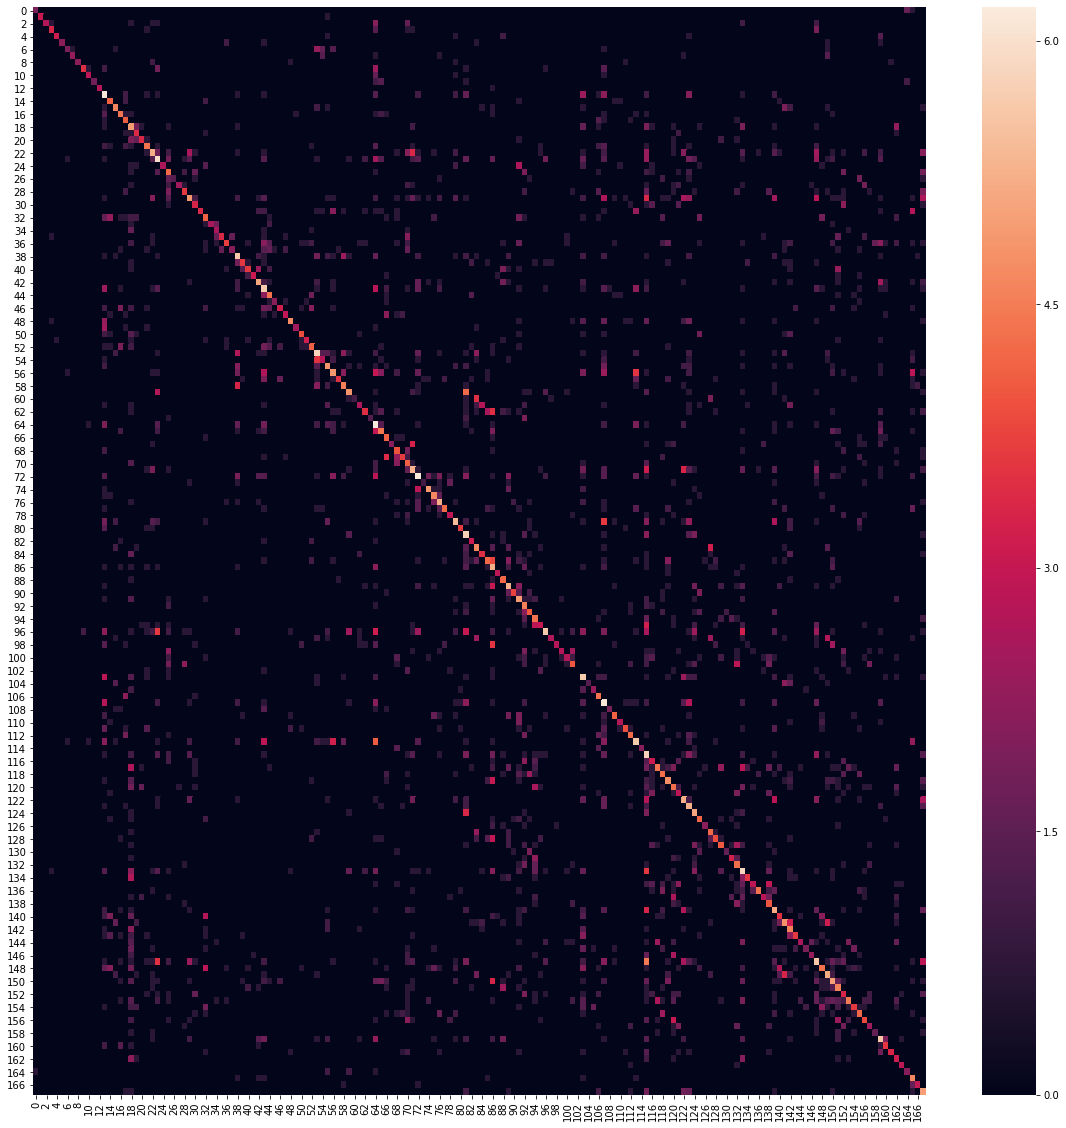

0.1805848803115198 0.05870232154951425 0.05727594395755197 0.0646066148044536


0.08347405294027133 (0.00895799540832073, 0.025416695748609077, 0.04909936178334152)
0.724882919848899
0.9357353171576895
0.9364630135462101
[[4116   27    8    2   61    8    4   20    2    0    0]
 [ 148 3455    5   14   12    6    2    4    2   14    0]
 [   4    0 2571    1    1    0    0    0    0    0    0]
 [   7   13    1 1557    0    0    0    0    0    1    0]
 [  90    0    0    0 1774   14    1    2    0    0    0]
 [  32    1    0    0   27  457    5    0    0    0    0]
 [  60    0    0    0    4   25  359    0    0    0    0]
 [  10    0    4    0    2    0    0 2811   10   22    0]
 [   0    0    3    0    0    0    0   21  306    2    1]
 [   0    6    0    0    0    0    0   57    2 1547    6]
 [   0    0    0    3    0    0    0    7    0   19  328]]
[[12237     6    39     0    15   257     1]
 [   29   651     7     0     1     5     0]
 [  188     1  2091     1     3    24     0]
 [    1     0     2    58     1     0     0]
 [  171     0     5     3  1909    17   

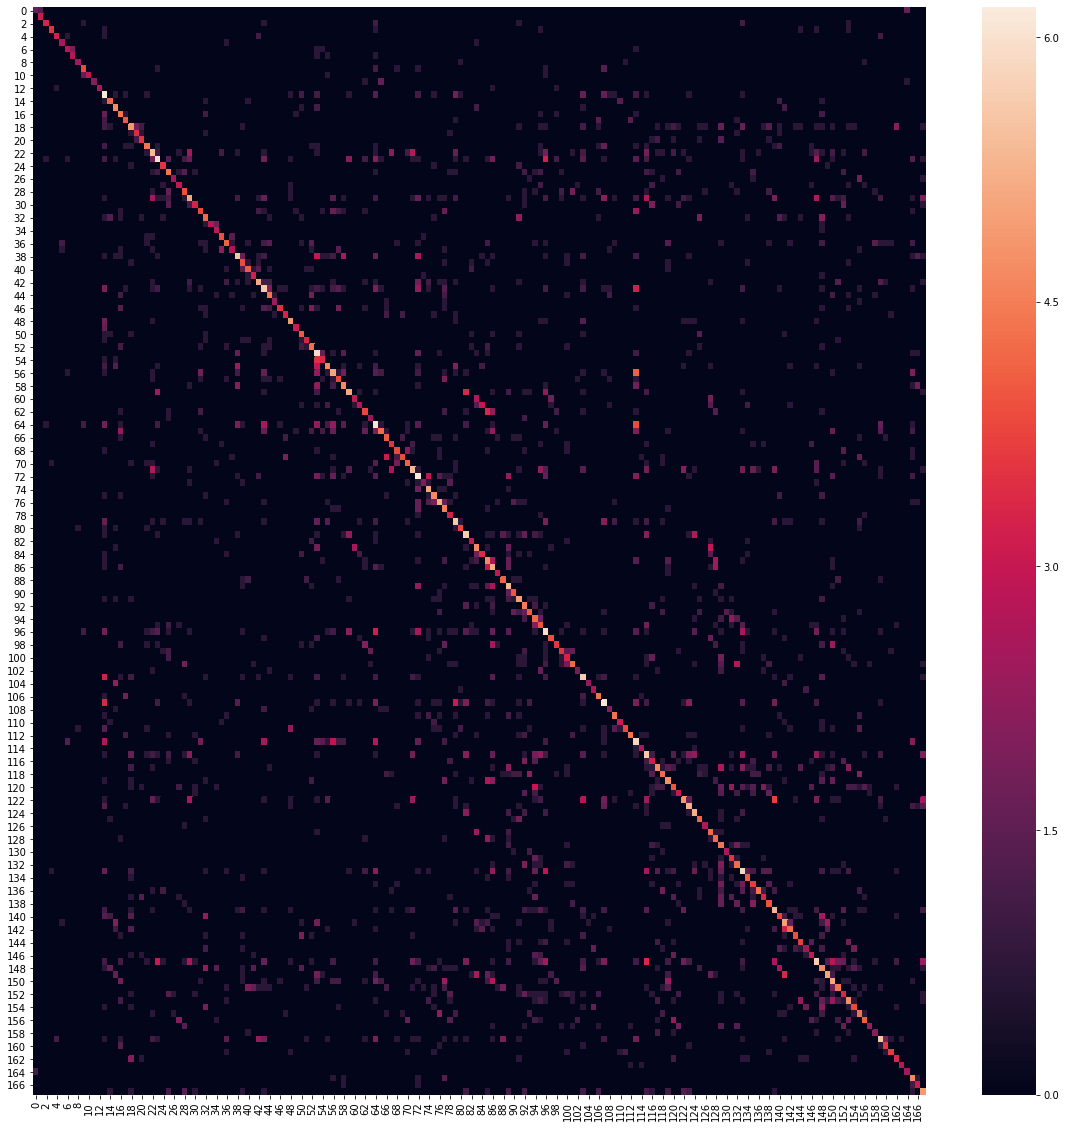

0.16433041762178427 0.05351564871289542 0.052020953032184826 0.058793815876704035


0.12305615079600976 (0.010434635584773142, 0.05699939775881888, 0.05562211745241775)
0.6770282124937579
0.9268515561826424
0.9093213862483426
[[3217  754    4    7   54   92   78   38    2    2    0]
 [   5 3632    0    9    0    1    0    0    0   14    1]
 [   3    2 2567    1    0    0    0    3    0    1    0]
 [   1   57    0 1517    0    0    0    0    0    0    4]
 [  49   91    0    1 1653   66   17    4    0    0    0]
 [   8   15    0    0    5  482   12    0    0    0    0]
 [   7    6    0    0    1   24  410    0    0    0    0]
 [   5    8    1    0    0    1    0 2681    4  147   12]
 [   0    1    1    0    0    0    0   18  299    9    5]
 [   0   12    0    0    0    0    0    7    1 1565   33]
 [   0    0    0    0    0    0    0    2    0    9  346]]
[[12314    25    72     0   109    35     0]
 [   12   670     9     0     1     1     0]
 [  152    11  2131     2     6     6     0]
 [    0     0     2    54     6     0     0]
 [   54     0     6     0  2083     0  

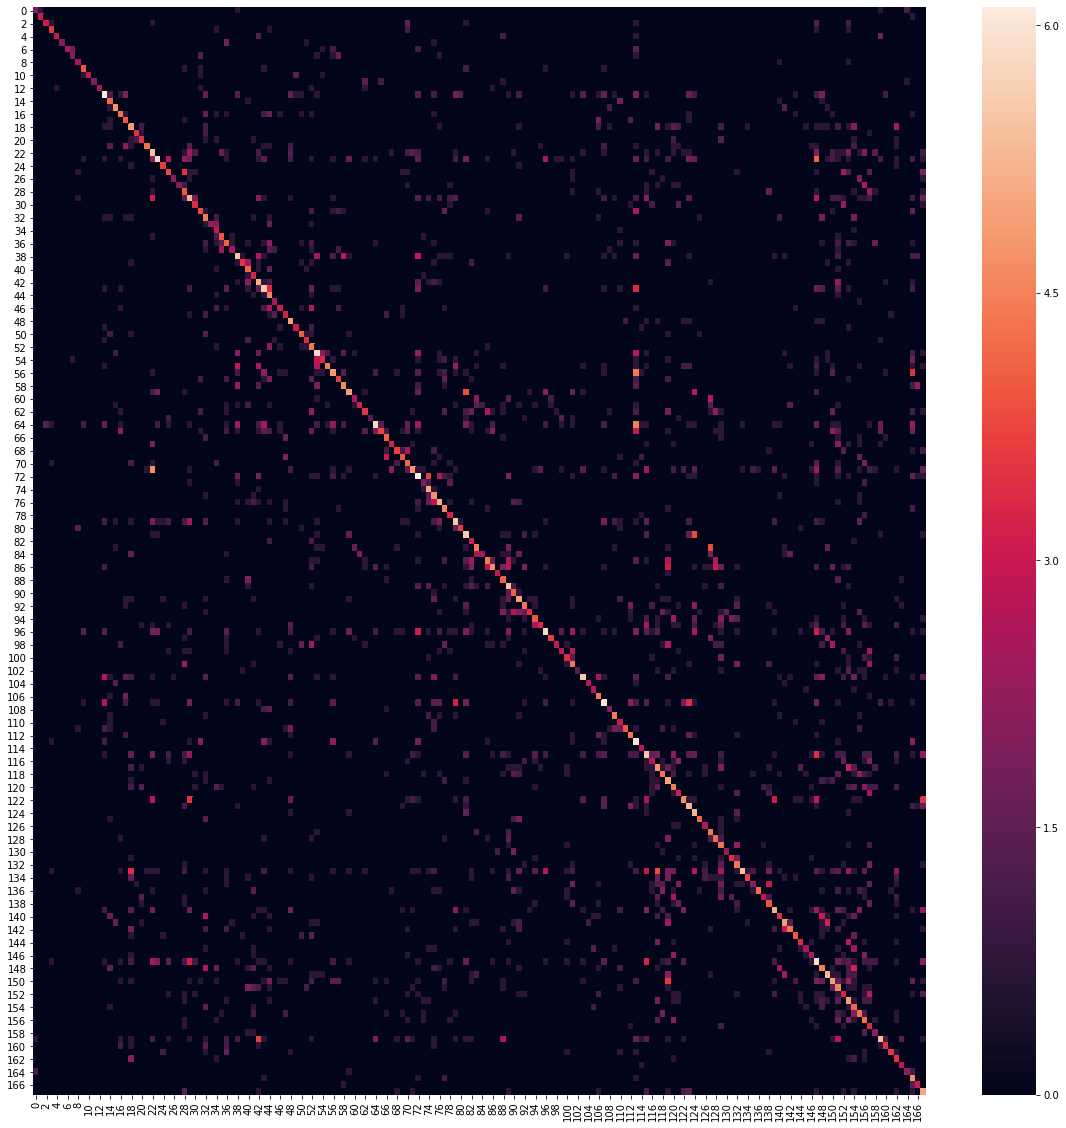

0.1509601653480526 0.04921871484933289 0.04769865084989244 0.054042799648827244


0.07594997802442766 (0.007503969948503036, 0.026010335647041284, 0.04243567242888333)
0.7526342931556643
0.9518289645699155
0.9324454151873406
[[4017   67    1    4  110   20   22    7    0    0    0]
 [  54 3574    0   17    3    1    4    1    0    7    1]
 [   8    2 2564    1    1    0    0    1    0    0    0]
 [   5   13    0 1561    0    0    0    0    0    0    0]
 [  40    1    0    0 1814   11   15    0    0    0    0]
 [  12    9    0    0   30  444   27    0    0    0    0]
 [  12    0    0    0    2    3  431    0    0    0    0]
 [  34    5    1    1    4    0    1 2782    8   22    1]
 [   2    1    4    0    0    0    0   19  305    1    1]
 [   0   32    0    0    0    0    0   43    3 1518   22]
 [   0    0    0    1    0    0    0    5    0    8  343]]
[[12305    12    93     0    22   123     0]
 [   11   671    10     0     1     0     0]
 [  103     8  2187     0     0    10     0]
 [    1     0     3    57     1     0     0]
 [  124     0    10     0  2006     2 

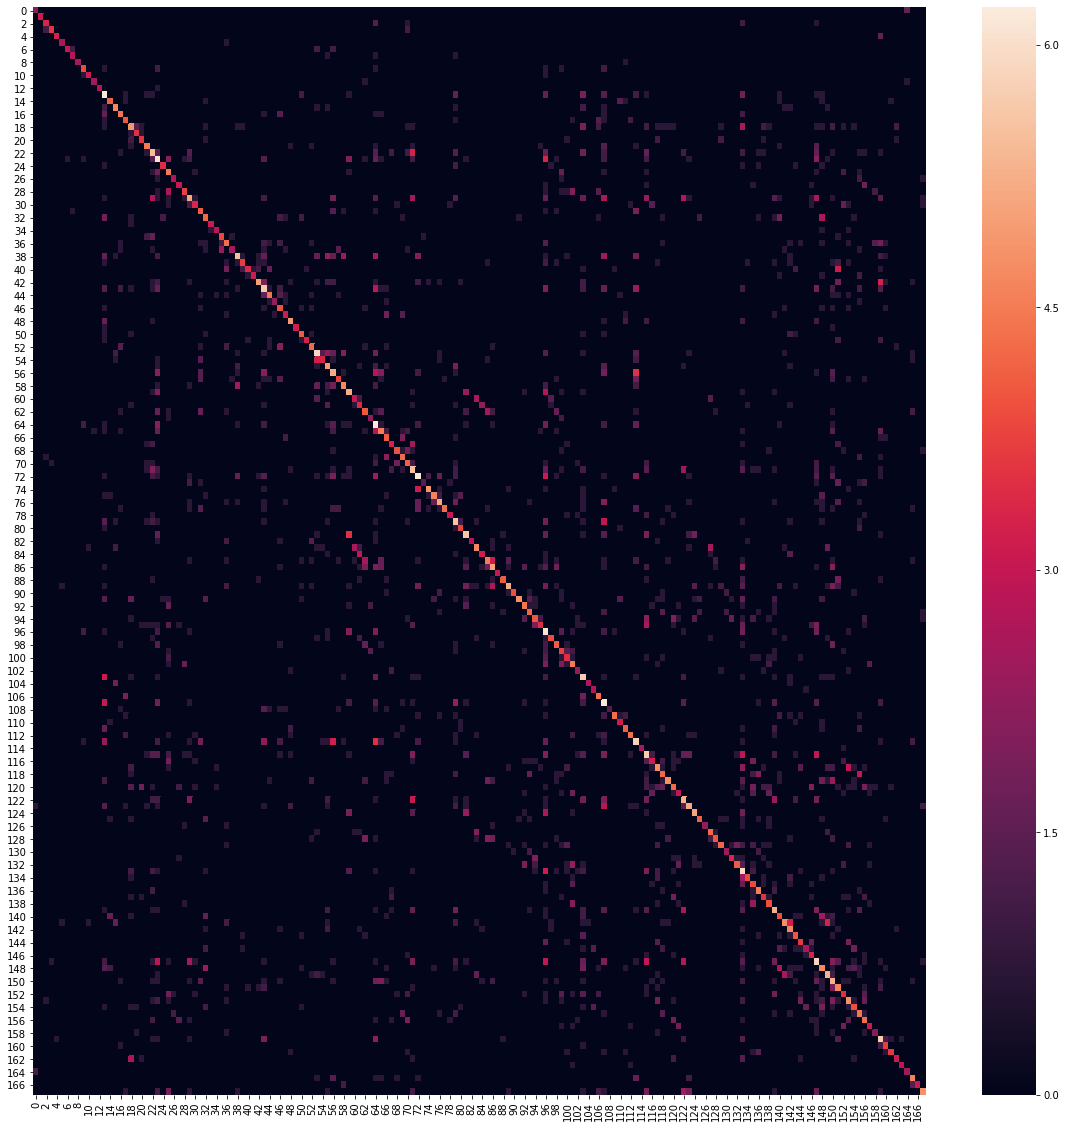

0.13955092896893326 0.04558614117493181 0.04405035743082559 0.04991443036317587


0.09118643935911264 (0.008345871173505541, 0.03705485440979275, 0.045785713775814335)
0.7327612062854901
0.9358240915555914
0.9382479113622566
[[3825  298    4   16   64   23    6   10    2    0    0]
 [  12 3627    0   12    0    0    1    0    0    9    1]
 [   7    0 2563    2    1    0    0    3    0    1    0]
 [   1   21    0 1556    0    0    0    0    0    1    0]
 [  67   13    1    1 1784   12    2    1    0    0    0]
 [  17   16    0    0   27  453    9    0    0    0    0]
 [  20    4    0    0    4   10  410    0    0    0    0]
 [  19    7    2    1    1    0    1 2644    7  174    3]
 [   0    3    2    0    0    0    0   20  291   17    0]
 [   0   26    0    0    0    0    0    4    0 1581    7]
 [   0    0    0    6    0    0    0    2    0   22  327]]
[[12167    32    59     0   108   187     2]
 [   10   673     8     0     1     1     0]
 [  142    19  2121     3     9    14     0]
 [    0     0     1    57     4     0     0]
 [   33     0     0     0  2104     3 

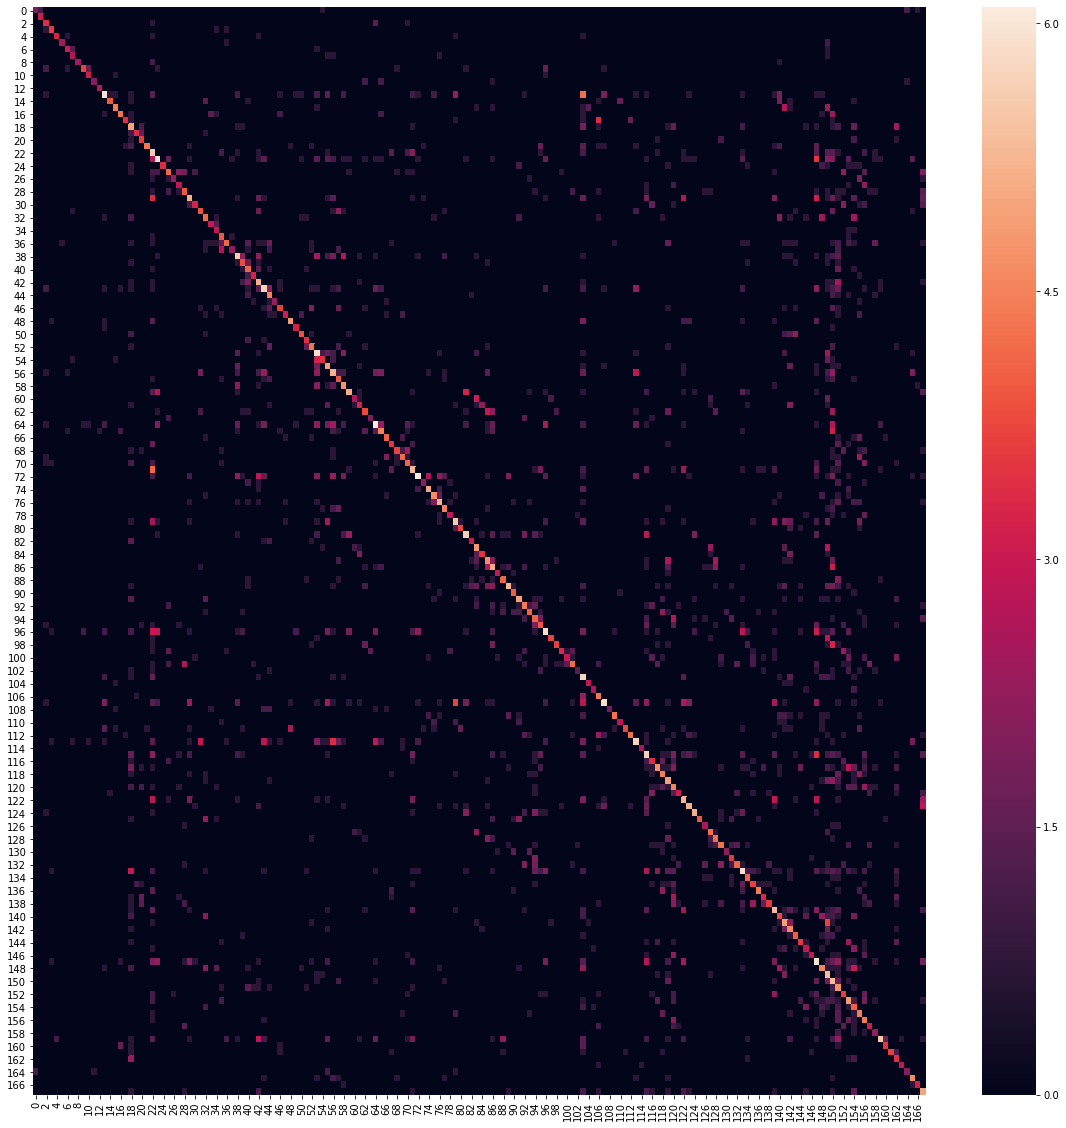

0.12977894290490832 0.04247429605123309 0.04090018806479859 0.04640445878887666


0.0809024952446358 (0.006799259270199492, 0.029947456137477596, 0.044155779836958724)
0.78203447217367
0.9358358270864521
0.9558097882965237
[[4099   35    4    1   67   14    0   21    7    0    0]
 [ 126 3491    0   10    5    6    1    2    2   18    1]
 [   8    0 2563    1    0    0    0    2    2    1    0]
 [  10   17    0 1548    0    0    0    0    0    0    4]
 [  80    0    0    0 1770   25    1    5    0    0    0]
 [  27    0    0    0   22  471    1    1    0    0    0]
 [  55    0    0    0    3   57  332    1    0    0    0]
 [  13    0    1    0    1    0    0 2798   16   29    1]
 [   1    0    0    0    0    0    0   15  315    1    1]
 [   0    4    0    0    0    1    0   61    3 1534   15]
 [   0    0    0    0    0    0    0    6    0   14  337]]
[[12183    56    74     0    93   145     4]
 [   10   676     6     0     1     0     0]
 [   93    31  2166     3     3    12     0]
 [    0     0     2    60     0     0     0]
 [   57     3     3     0  2063     1   

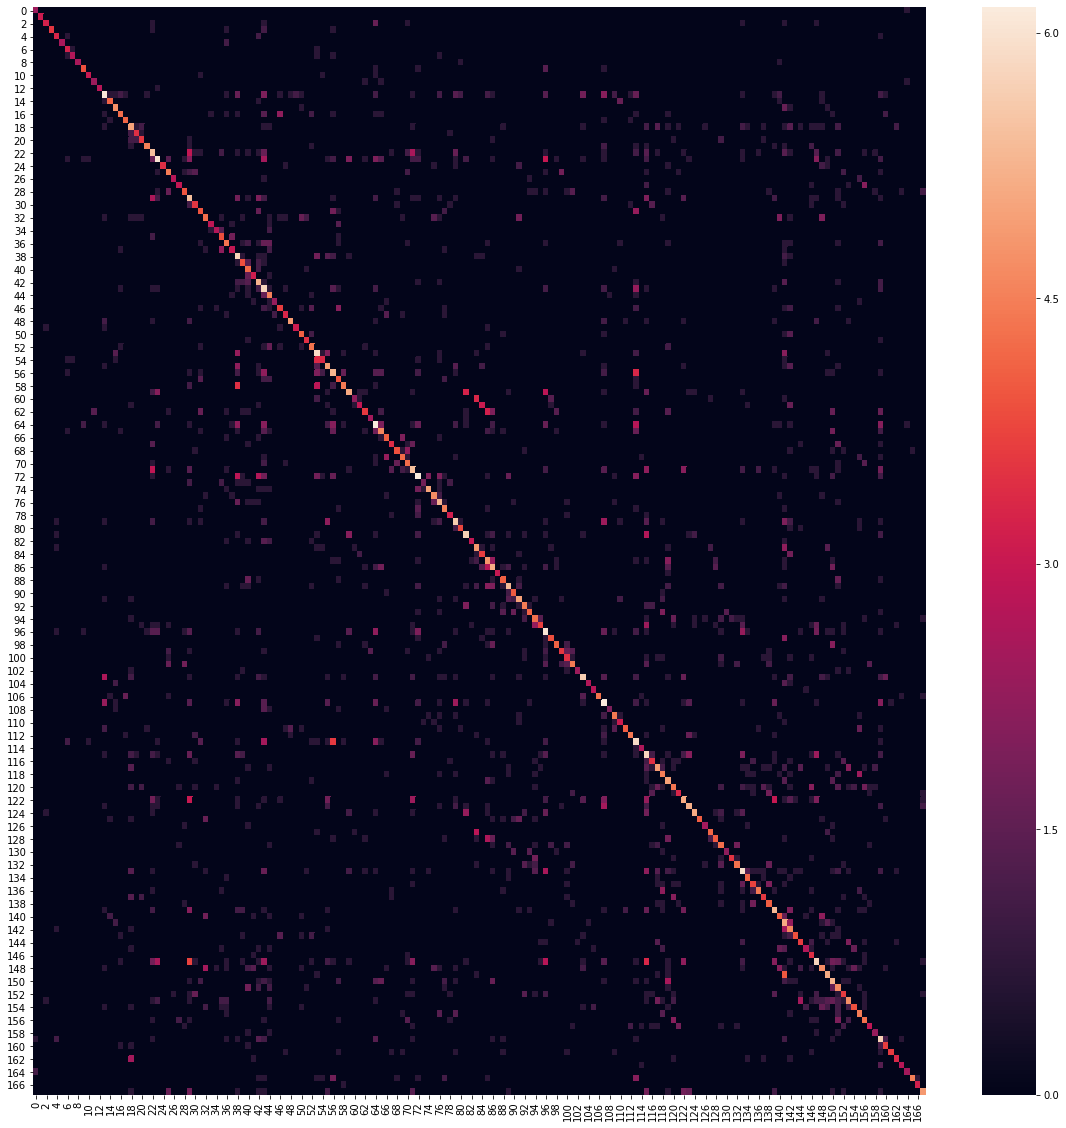

0.12139943890380142 0.03978267406341807 0.038212555595586235 0.04340420924479712


0.09147662783772509 (0.007230644609449031, 0.031640084648999985, 0.05260589857927606)
0.7676174133421405
0.9523092245505992
0.8860196800244063
[[3848  149    5   10  151   21   34   26    3    1    0]
 [  17 3600    0   18    2    0    2    0    0   22    1]
 [   5    0 2565    1    1    0    0    1    1    1    2]
 [   1   14    0 1563    0    0    0    0    0    1    0]
 [  30    3    0    0 1830    5   12    1    0    0    0]
 [  13   10    0    0   39  451    9    0    0    0    0]
 [  10    1    0    0    8   13  416    0    0    0    0]
 [   9    1    1    1    1    1    1 2690   14  136    4]
 [   0    0    0    0    0    0    0   12  313    6    2]
 [   0    9    0    0    0    0    0    4    1 1586   18]
 [   0    0    0    1    0    0    0    2    0    6  348]]
[[12389     8   100     0    17    41     0]
 [   16   662    14     0     1     0     0]
 [  112     4  2183     0     0     9     0]
 [    0     0    16    45     1     0     0]
 [  149     0    12     0  1979     3 

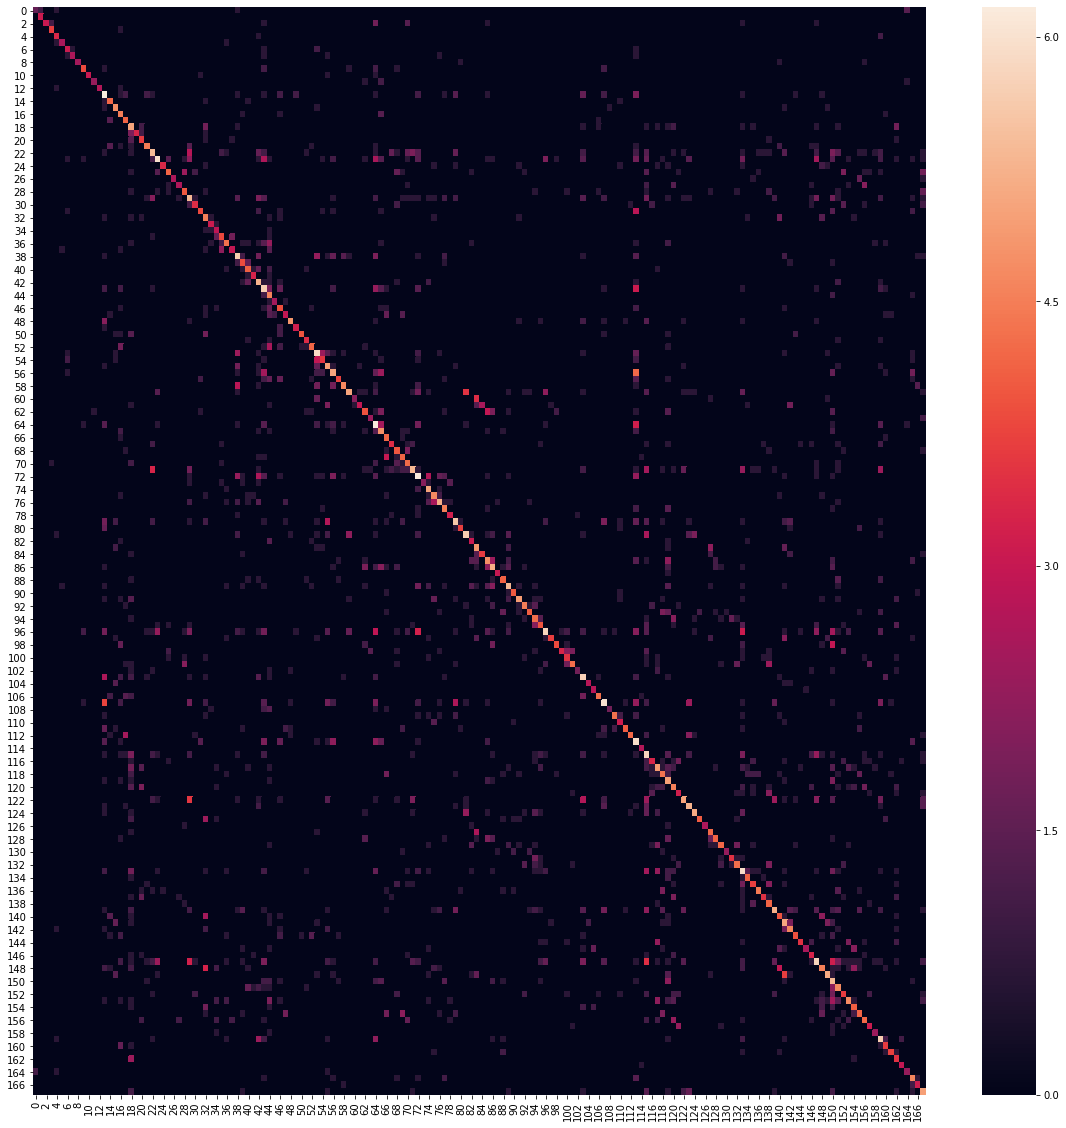

In [39]:
run_epochs(7)